In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import fastai as meta_fai
import fastai.basics as fai
import fastai.vision as fv
import torch
import pandas as pd
import gc

In [5]:
fai.URLs.PLANET_SAMPLE

'http://files.fast.ai/data/examples/planet_sample'

In [6]:
planet = fai.untar_data(fai.URLs.PLANET_SAMPLE)

In [7]:
planet

PosixPath('/home/holydemon/.fastai/data/planet_sample')

In [8]:
!ls {planet}

labels.csv  train


In [9]:
!head {planet}/labels.csv

image_name,tags
train_21983,partly_cloudy primary
train_9516,clear cultivation primary water
train_12664,haze primary
train_36960,clear primary
train_5302,haze primary road
train_13350,clear primary
train_19547,agriculture clear primary road
train_31388,partly_cloudy primary
train_32079,partly_cloudy primary


In [10]:
!ls {planet}/train | head

train_10001.jpg
train_10007.jpg
train_10030.jpg
train_10033.jpg
train_1004.jpg
train_10042.jpg
train_10075.jpg
train_10082.jpg
train_10084.jpg
train_10098.jpg
ls: write error: Broken pipe


In [11]:
tfms = fv.get_transforms(flip_vert=True, max_rotate=360, max_lighting=0.1, max_zoom=1.05,max_warp=0.05)

In [24]:
def load_planet_data(img_size, batch_size):
    return (fv.ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
              .random_split_by_pct(0.2, seed=666) #pct = percentage
              .label_from_df() #dataframe
              .transform(tfms, size=img_size)
              .databunch(bs=batch_size)
              .normalize(fv.imagenet_stats))


In [25]:
data = load_planet_data(256, 64)

/home/holydemon/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:486: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
agriculture habitation partly_cloudy road, clear habitation primary selective_logging, partly_cloudy primary road water conventional_mine, agriculture clear cultivation primary road selective_logging slash_burn water, agriculture clear cultivation habitation primary road selective_logging...
  if getattr(ds, 'warn', False): warn(ds.warn)


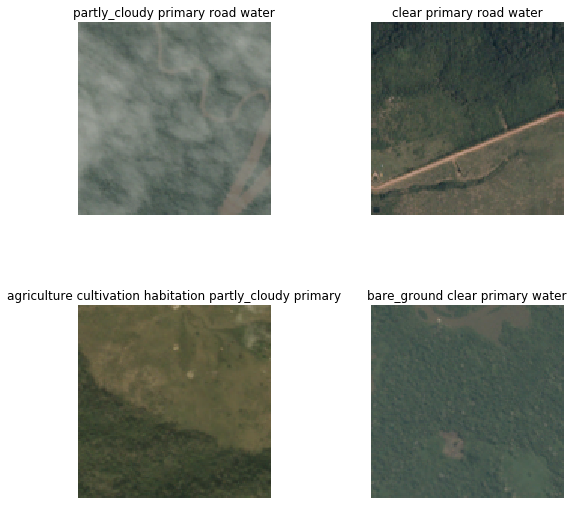

In [17]:
data.show_batch(rows=2)

In [27]:
fai.accuracy??

Signature: fai.accuracy(input:torch.Tensor, targs:torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f461f947268>
Source:   
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()
File:      ~/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/metrics.py
Type:      function


In [28]:
fai.fbeta??

Signature:
fai.fbeta(
    ['y_pred:torch.Tensor', 'y_true:torch.Tensor', 'thresh:float=0.2', 'beta:float=2', 'eps:float=1e-09', 'sigmoid:bool=True'],
) -> <function NewType.<locals>.new_type at 0x7f461f947268>
Source:   
def fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()
File:      ~/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/metrics.py
Type:      function


In [29]:
def f2_score_01(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.1, beta=2)
def f2_score_02(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.2, beta=2)
def f2_score_025(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.25, beta=2)
def f2_score_03(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.3, beta=2)
def f2_score_04(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.4, beta=2)

In [30]:
metrics = [f2_score_01, f2_score_02, f2_score_025, f2_score_03, f2_score_04]
learn = fv.create_cnn(data, fv.models.resnet50, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/holydemon/.torch/models/resnet50-19c8e357.pth
102502400it [01:23, 1229413.03it/s]


In [31]:
learn.lr_find()
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 KiB (GPU 0; 1.96 GiB total capacity; 1.55 GiB already allocated; 1.69 MiB free; 11.17 MiB cached)

In [ ]:
learn.fit_one_cycle(5,3e-2)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,max_lr=4e-3)

In [ ]:
torch.save(learn.model.state_dict(), "planet/models/stage-1-r50.pth")

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(3e-5,8e-4))

In [ ]:
learn.show_results(rows=3)

In [ ]:
learn.save("stage-2-r50")

In [ ]:
img_sizes = [256, 512, 768, 1024]
batch_sizes = [64, 64, 48, 32]

In [ ]:
lr = 1e-3
for sz, bs in zip(img_sizes, batch_sizes):
    learn.data = load_planet_data(sz,bs)
    gc.collect()
    learn.fit_one_cycle(8, slice(lr/10, lr))
    learn.save(f"stage3-r50-{sz}")